In [1]:
import pandas as pd
import numpy as np
from lmfit import minimize, Parameters
import scipy.integrate as scint
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
def bee_eq(y, t, w1,w2, env_temp,h, solar, k_W, k_A_W, k_hive, eta_W, 
           eta_A_W, eta_B_W, theta_ideal, k_c, P_C):
    hive_temp = y
    M = -h*(w1*w2*(1-np.exp(-hive_temp+theta_ideal)) / (w2+w1*np.exp(-hive_temp+theta_ideal)))
    W = 4*(k_W + k_c + k_hive)*(-hive_temp + env_temp) + 4*eta_W*solar 
    A_W = (k_A_W+k_hive)*(-hive_temp + env_temp) + eta_A_W*solar
    B_W = (k_W+k_hive)*(-hive_temp + env_temp) + eta_B_W*solar
    dydt = M + W + A_W + B_W - P_C
    return dydt

def run_bee_eq(t, a, w1,w2, env_temp,h, solar, k_W, k_A_W, k_hive, eta_W, eta_A_W, eta_B_W, theta_ideal, k_c, P_C):
    sol = scint.odeint(bee_eq, a, t, args=(w1,w2, env_temp,h, solar, k_W, k_A_W, k_hive, 
                                           eta_W, eta_A_W, eta_B_W, theta_ideal, k_c, P_C), 
                                           col_deriv = True, rtol = 10e-3, atol = 10e-3)
                                           #hmin = 0.001) #w' and 'amplitude_temp_ext'
    theta_t = sol[-1,:]
    return theta_t    

In [24]:
def residual(ps, ts, data, l, argv):
    d = pd.DataFrame(data).groupby(data['Date'])
    model = []
    k = 0
    alpha  = 1
    r_c = 115 #29 #ps['w1'].value
    r_h = 1094 #280 #ps['w2'].value
    h_ = [1]
    return_value = []
    for m,n in d:
        h = ps['h_'+str(k)].value #health factor per day
        theta_ideal = ps['theta_'+str(k)].value + 273.15 #theta_ideal per day
        t_max = len(n[argv[1]])-1
        t = np.linspace(0,t_max, num = t_max+1)
        environment_temp = n[argv[1]].values + 273.15 #hourly environment temperature -> kelvin
        solar_rad = n[argv[2]].values #hourly solar radiation -> kelvin
        k_W = 1 #thermal conductivity of wood -> per hour
        eta_W = 0.0*k_W #heat absorption coeff of wood
        k_A_W = k_W #thermal conductivity of top surface (wood + aluminum plate) -> per hour
        eta_A_W = eta_W #heat absorption coeff of top surface
        eta_B_W = eta_W #heat absorption coeff of bottom surface
        k_hive = 1
        k_c = 0
        if n['Treatment'].values[0] == 1:
            P_C = n['P_3'].values
        else:
            P_C = 0
        
        a = [1]*len(environment_temp)
        
        fitted = run_bee_eq(t, a, r_c, r_h, environment_temp, h, solar_rad, k_W, k_A_W, 
                            k_hive, eta_W, eta_A_W, eta_B_W, theta_ideal, k_c, P_C)
        model = np.concatenate((model, fitted - 273.15))
        try:
            h_.append(abs(h - ps['h_'+str(k-1)].value))
        except:
            h_.append(abs(h_[k] - h))
        k = k+1
    return_value = np.concatenate((return_value, (model - data[argv[3]]).ravel()))
    return_value = np.concatenate((return_value, l*np.array(h_[2:]).ravel()))
    #print(np.mean(abs((model - data[argv[3]]).ravel())))
    return return_value

In [25]:
def main(*argv):
    data = pd.read_csv(argv[0])
    d = pd.DataFrame(data).groupby([data['Date']])
    
    h_max = 1
    l = 96/h_max

    forecasted_all = []

    for i in range(0,int(len(data)/24) - 21 + 1):
    #for i in range(1):
        print('hello', i)
        data_all = data[i*24:24*(i+21)] #input + forecast -> 8 days
        data_input =  data[i*24:24*(i+7)] #7 days input for forecasting
        data_temp_input = data_input[argv[3]][0:24*7] #7 days hive core temperature for forecasting -> celcius
        data_ext_input = data_input[argv[1]][0:24*7] #7 days environment temperature for forecasting -> celcius
        #P_C = data_input['P'][0:24*7]
        params = Parameters()
        for j in range(7):
            params.add('h_'+str(j), value = 0.5, min = 0.1, max = h_max)
            params.add('theta_'+str(j), value = 35, min = 33, max = 38)   
        t_max = len(data_ext_input)-1
        t = np.linspace(0,t_max, num = t_max+1)

        result = minimize(residual, params, args=(t,data_input, l, argv),
                          method='leastsq',nan_policy='omit',max_nfev = 300)
        sig_min = data_temp_input + result.residual[:len(data_temp_input)].reshape(data_temp_input.shape)
        
        plt.figure(figsize = (10,4), dpi = 200)
        plt.plot(data_temp_input, label = 'Hive Core Temperature', color = 'blue')
        plt.plot(sig_min, label = 'Forecasted Core Temp', color = 'red') 
        plt.xlabel('Samples per hour')
        plt.ylabel('Temperature in celcius')
        plt.legend()
        plt.show()
        param_min_h,param_min_theta = [], []
        for m in range(7):
            param_min_h.append(result.params['h_'+str(m)].value)
            param_min_theta.append(result.params['theta_'+str(m)].value)
            
        ##one day ahead forecast 
        forecast_h = param_min_h[-1]
        forecast_theta = param_min_theta[-1]
        
        h = forecast_h
        theta_ideal = forecast_theta + 273.15
        #theta_ideal = result.params['theta_'+str(6)].value + 273.15
        
        env_temp_future = data_all[argv[1]][7*24:21*24].values + 273.15
        solar_rad_future = data_all[argv[2]][7*24:21*24].values
        hive_temp_future = data_all[argv[3]][7*24:21*24].values
        t = np.linspace(0,14*24-1, num = len(env_temp_future)) #forecast hourly
        a = [1]*len(t)
        r_c = 115 #29 #ps['w1'].value
        r_h = 1094 #280 #ps['w2'].value
        k_W = 1 #thermal conductivity of wood -> per hour
        eta_W = 0.0*k_W #heat absorption coeff of wood
        k_A_W = k_W #thermal conductivity of top surface (wood + aluminum plate) -> per hour
        eta_A_W = eta_W #heat absorption coeff of top surface
        eta_B_W = eta_W #heat absorption coeff of bottom surface
        k_hive = 1
        k_c = 0
        P_c = 0
        
        forecasted = run_bee_eq(t, a, r_c, r_h, env_temp_future, h, 
                                solar_rad_future, 
                                k_W, k_A_W, k_hive, eta_W, eta_A_W, eta_B_W, theta_ideal, k_c, P_c) - 273.15
        
        for n in forecasted:
            print(n)
        plt.figure(figsize = (10,4), dpi = 200)
        plt.plot(hive_temp_future, label = 'Hive Core Temperature', color = 'blue')
        plt.plot(forecasted, label = 'Forecasted Core Temp', color = 'red') 
        plt.xlabel('Samples per hour')
        plt.ylabel('Temperature in celcius')
        plt.legend()
        plt.show()
        forecasted_all = np.concatenate((forecasted_all, forecasted))
    
    return forecasted_all

hello 0


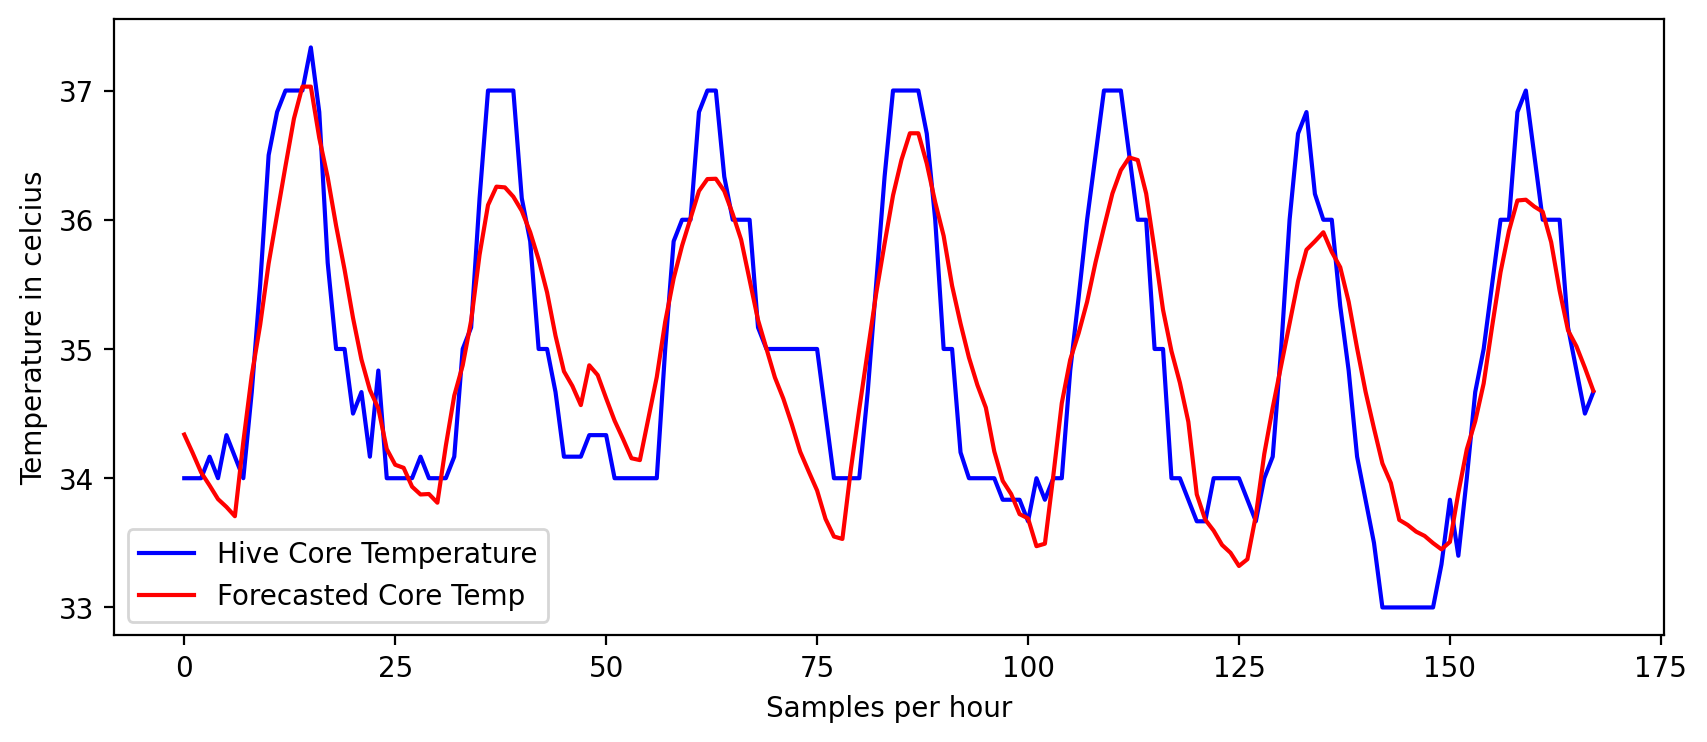

34.473705645525285
34.483062864581996
34.23331704526288
34.16324861885403
34.153119325719956
34.132765819422445
34.07090582406147
34.24321342511536
34.71262443385291
35.080784065962234
35.523942119549076
35.76179534272791
35.952508163922914
36.1939331895731
36.30548979710477
36.18187092078716
35.941566883140524
35.76179534272791
35.59174388115025
35.326368545970126
35.071793742363184
34.85667273745776
34.65816459951918
34.45494081333874
34.28253507180017
34.10198998697933
34.09166363086962
33.910276665471144
33.79755722042063
33.72737243842505
33.75099716821882
34.17334698771924
34.70356900102945
35.10778502420311
35.43831241405229
35.70080849841344
35.87682588516566
36.05310076874247
36.20605910655371
36.242829504368274
36.08754258164112
35.90900632696474
35.710894409978266
35.42889353561213
35.06280790545247
34.82975568107412
34.5665885789395
34.417198858884774
34.20346182857759
34.07090582406147
33.88812709698698
33.8205079665388
33.70350751592895
33.6179710263425
33.63039045132314


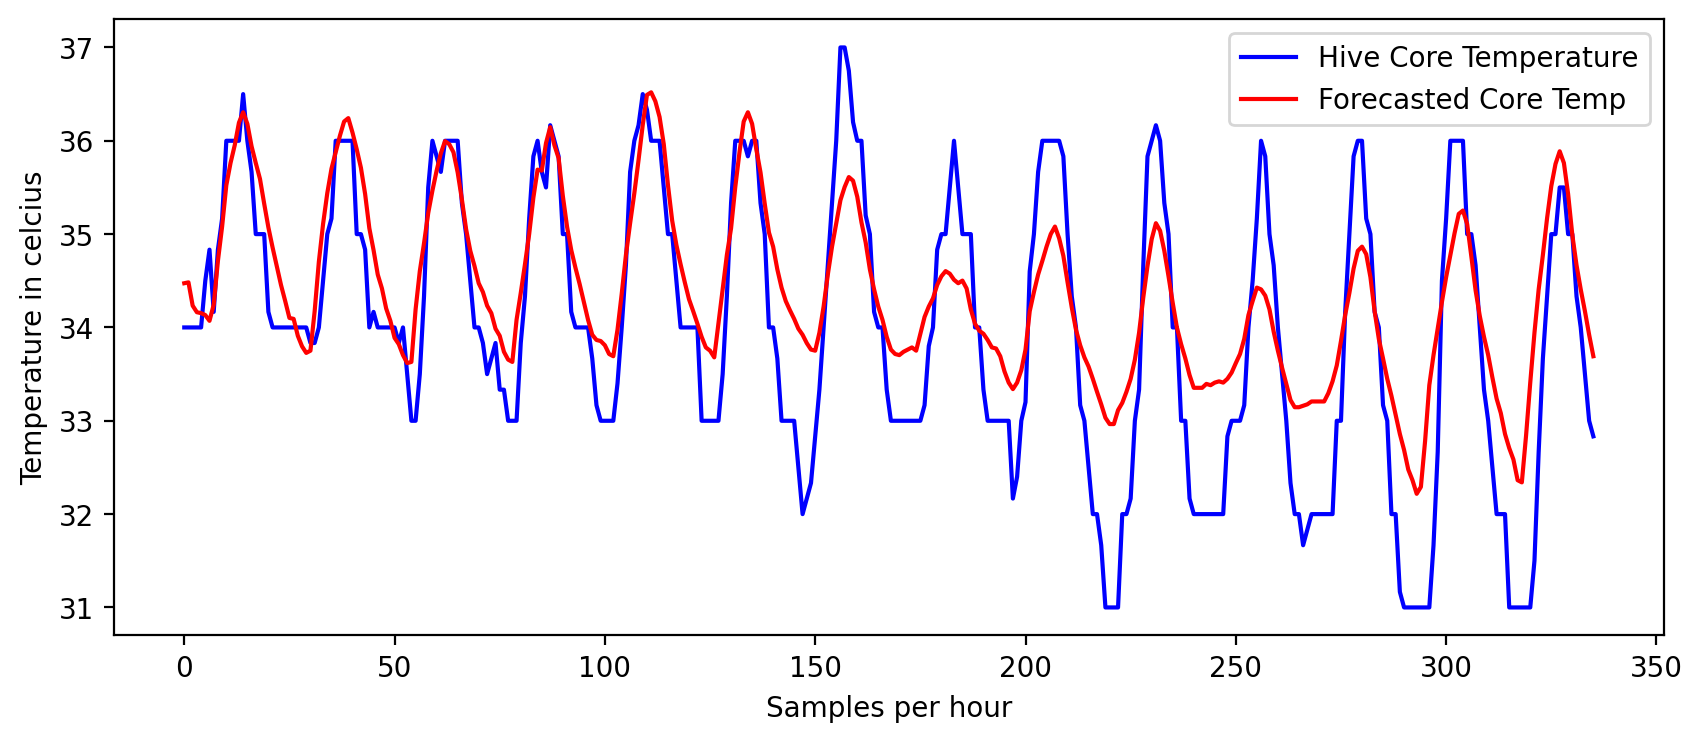

hello 1


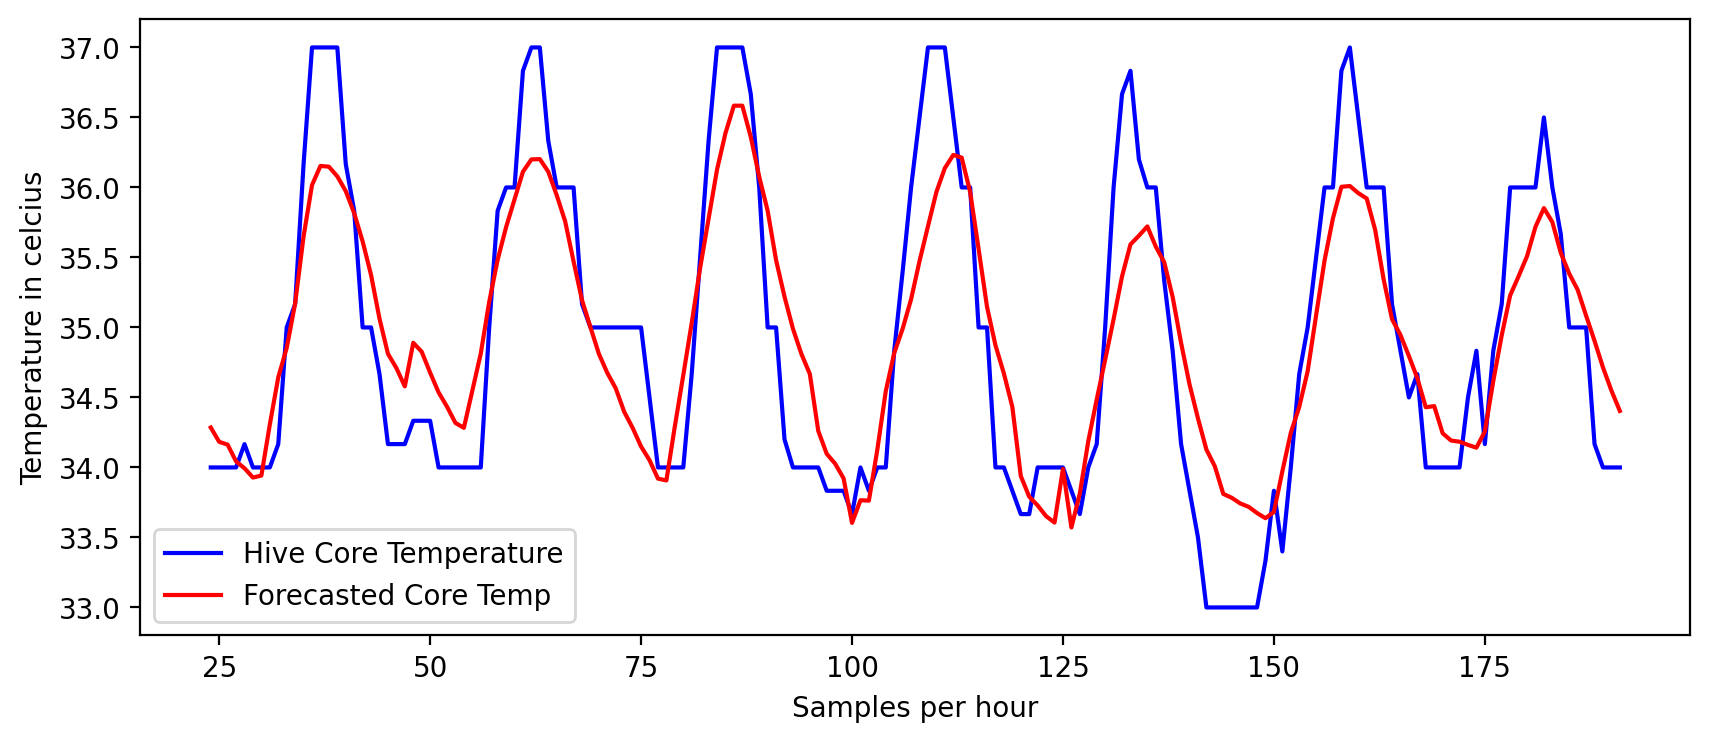

34.21706094482289
34.065757494808395
34.057219415536
33.90939159946947
33.819648628948755
33.764619506761846
33.783068603101526
34.125104932541205
34.58341242167097
34.94984572932543
35.25771433277532
35.50628233670858
35.67457860613871
35.844202423624495
35.99213775006075
36.02779264881167
35.87745658878026
35.705469241077594
35.51589352173238
35.24885625486547
34.90847396554392
34.696432107066755
34.46231218453363
34.33228835309427
34.150330849809336
34.040095397032985
33.89162586000373
33.83778609134288
33.746059862497646
33.68017950410416
33.689682407001385
34.14193527932116
34.49464757134575
34.76125628088192
35.05874265194808
35.284419120276596
35.48715813212141
35.66436762220894
35.789853041855224
35.75785267941609
35.67457860613871
35.46816155025772
35.19614011239281
34.900228760453274
34.68834586221203
34.54308212811134
34.381207612786625
34.299537144790975
34.17544245725179
34.10822045623587
33.970916019085735
33.90939159946947
33.77385765870622
33.70859492778021
33.689682407

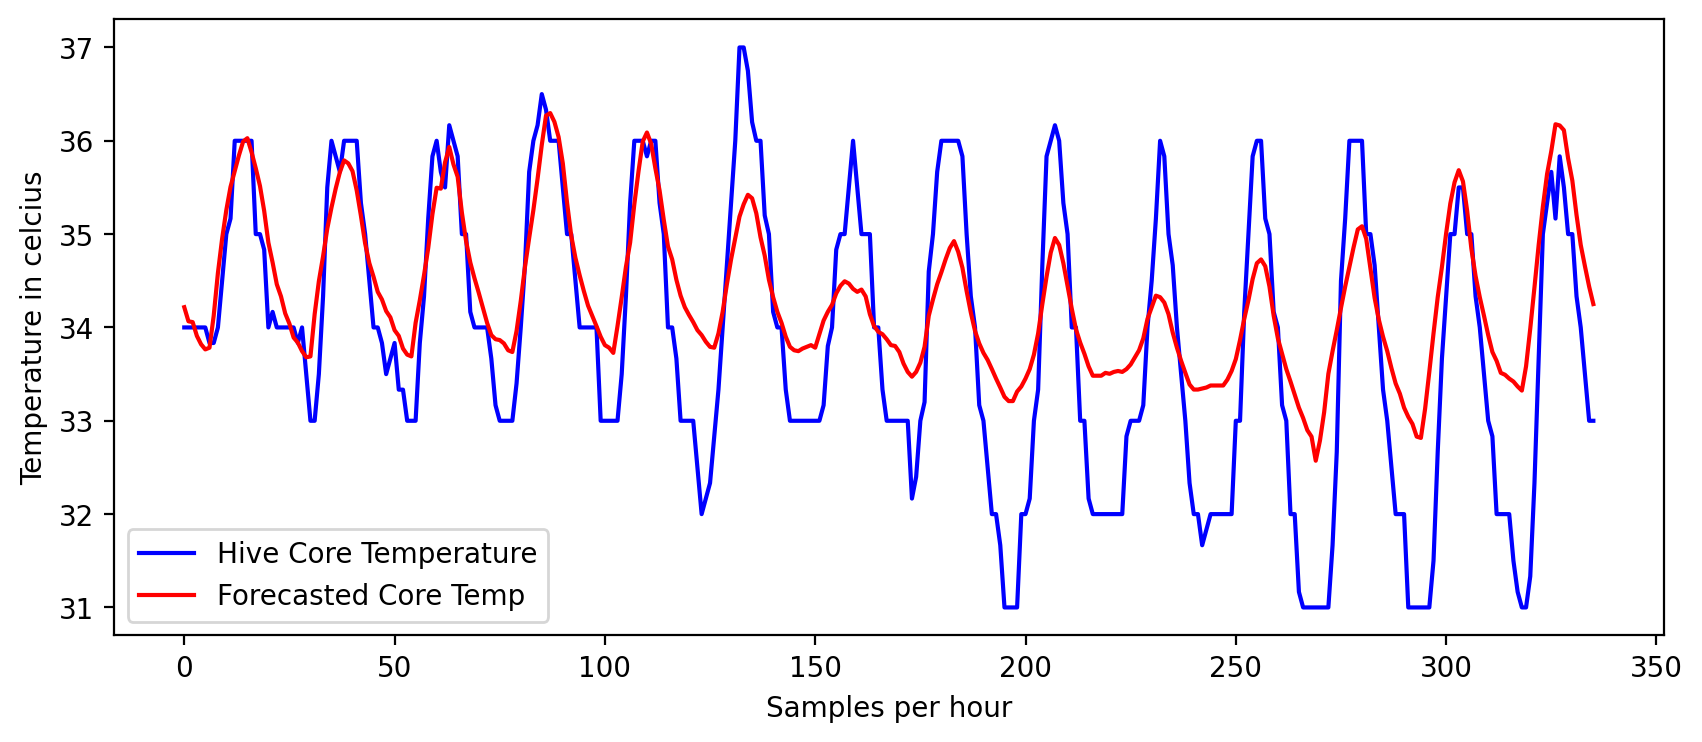

hello 2


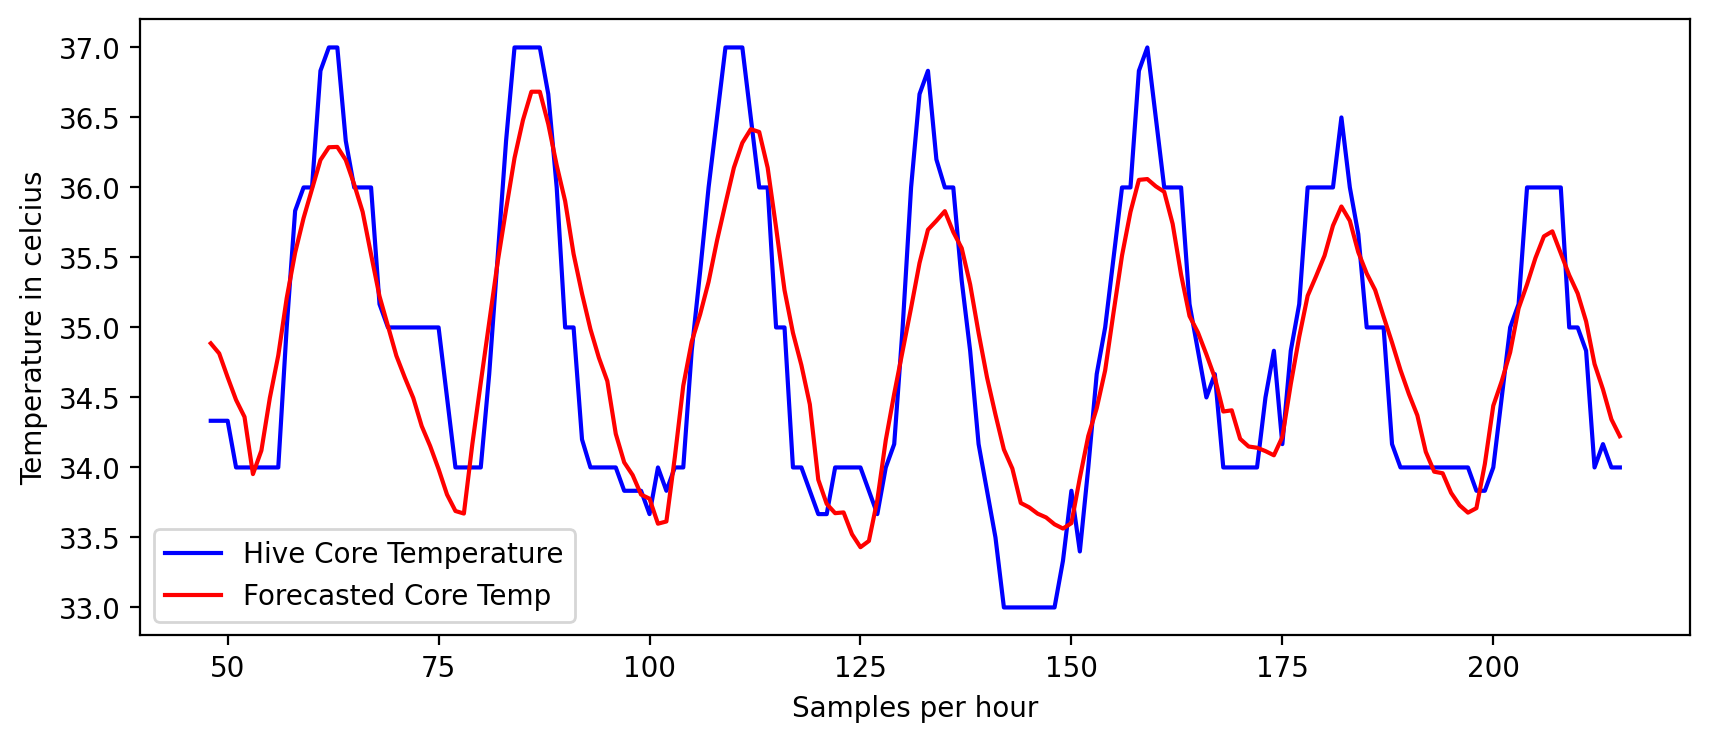

33.98067960635382
33.864323467678844
33.706765650739214
33.64936544564813
33.551218705671374
33.4804336051792
33.490659856501225
33.971835147515264
34.341325246783526
34.61841158250513
34.92620444859534
35.159179434351245
35.36836790388821
35.55129317818103
35.68094025252134
35.64786684752278
35.56183850034637
35.34876553510867
35.06807511232813
34.76233518431866
34.54277956261899
34.3917793081925
34.222913674464735
34.137430683887374
34.00711766659714
33.93628969477345
33.79103722877295
33.725674065417934
33.58101108627062
33.510995815863225
33.490659856501225
33.873387565319206
34.12882850871108
34.40857318747368
34.71132275780212
35.08612913721805
35.37821856011044
35.36836790388821
35.65883972321768
35.83007244891496
35.63694449941141
35.49921184107336
35.10426360819457
34.787953716752895
34.551172412640085
34.374974709338574
34.214405296426264
34.04215793310527
33.873387565319206
33.735088111146126
33.68774718183295
33.67819554518769
33.63969543453874
33.56118426399513
33.54121764

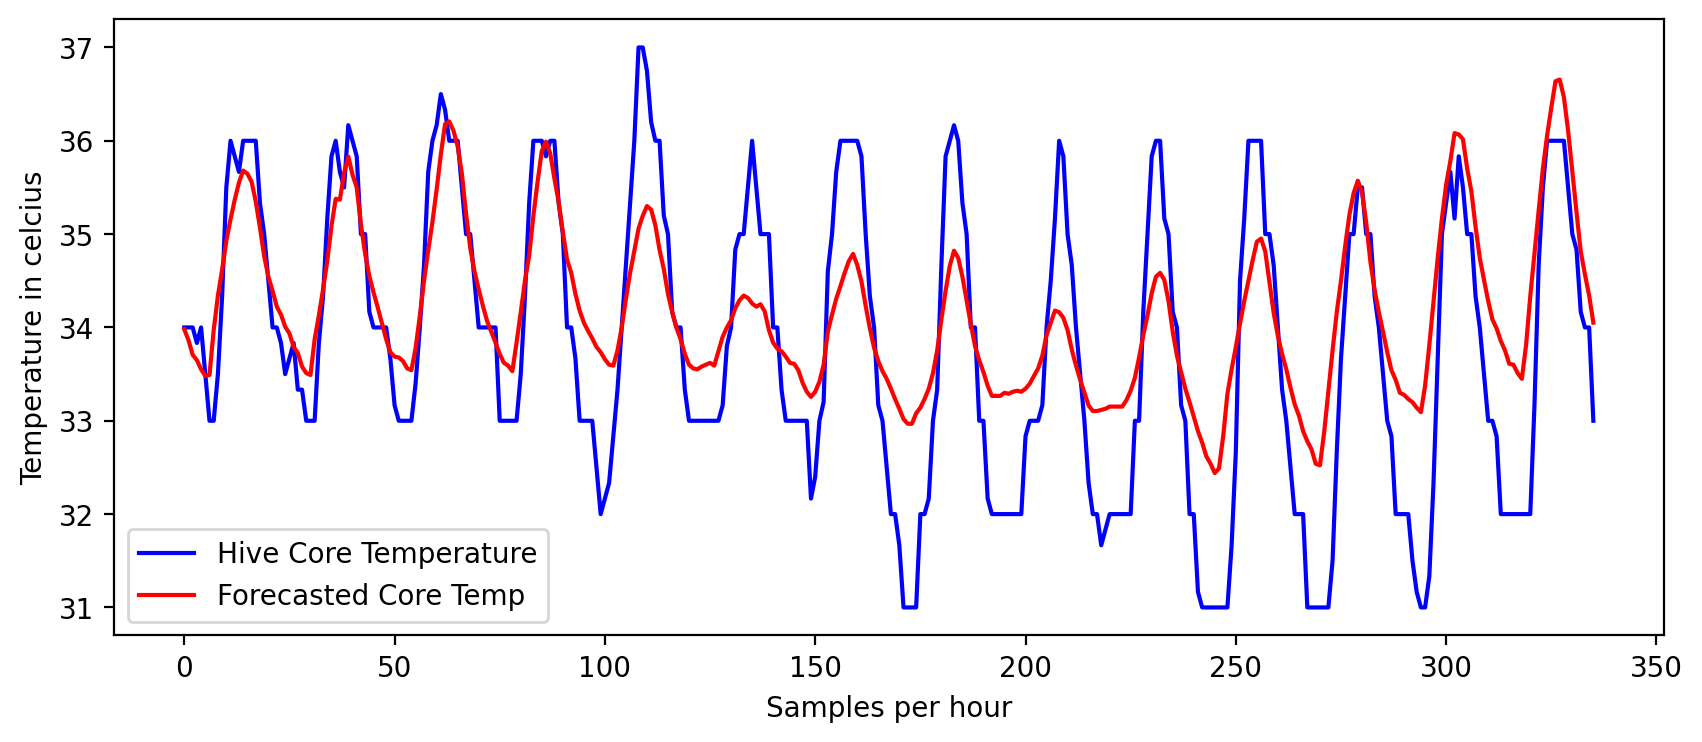

hello 3


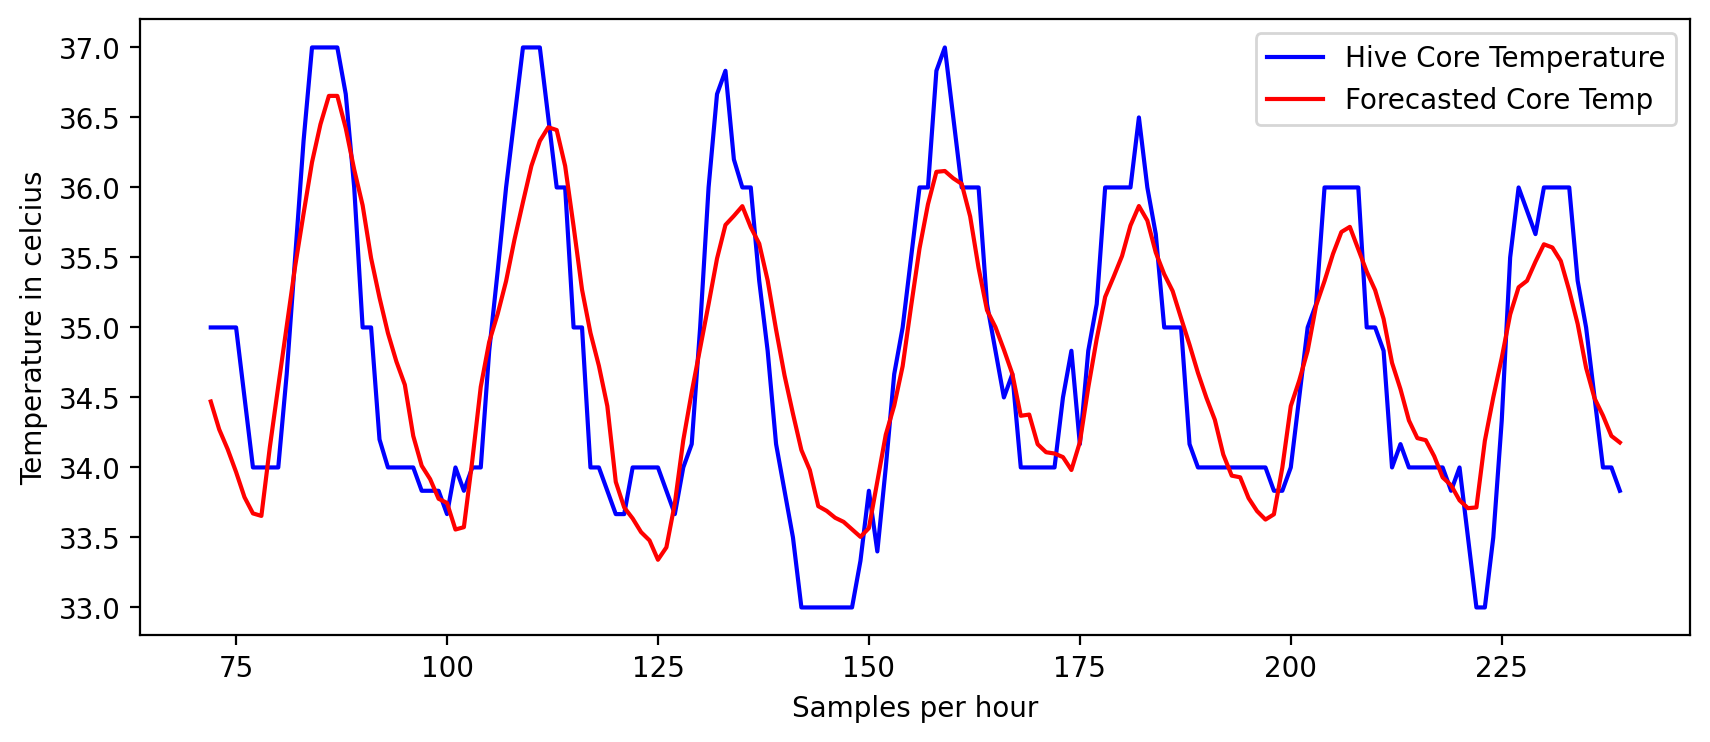

34.13296447711099
34.055690525448085
33.895737358468125
33.8230585721339
33.66050746944944
33.58093691524914
33.55770944631837
33.98667554025326
34.264742941995905
34.5633728799109
34.881047129474666
35.26818996133659
35.56620933759922
35.556203649065935
35.85007765902225
36.02227391381581
35.82800621460774
35.68887261118533
35.28677780325353
34.96069838456674
34.713635421122774
34.52778889441083
34.35669062117768
34.17103019990196
33.98667554025326
33.833554497697264
33.780674198096904
33.76997462573371
33.726741627991714
33.63803629931863
33.61535806549904
33.8854648714414
34.25545726486638
34.66073216063438
34.99625253027193
35.314798222102525
35.66807529287502
36.0462176050811
36.37021879202666
36.39846589156622
36.30128331168078
36.132096384759905
35.839018020628714
35.39995649058926
35.02299696903964
34.766476328639556
34.5633728799109
34.374900343176535
34.199351916935484
34.07516065007326
33.94658397747719
33.81252322994516
33.704854133788785
33.67166745475538
33.60393910926274

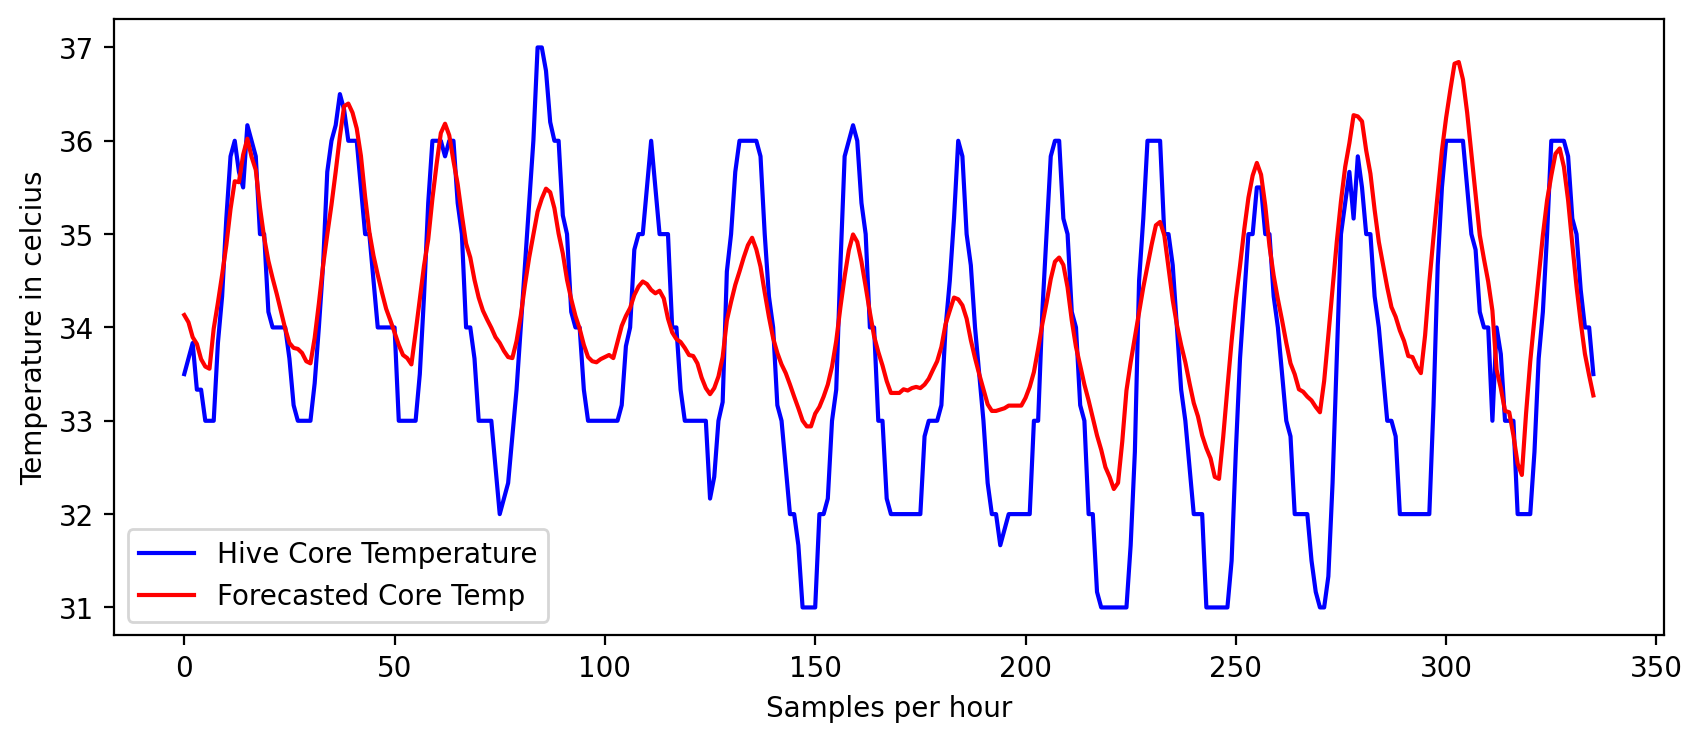

hello 4


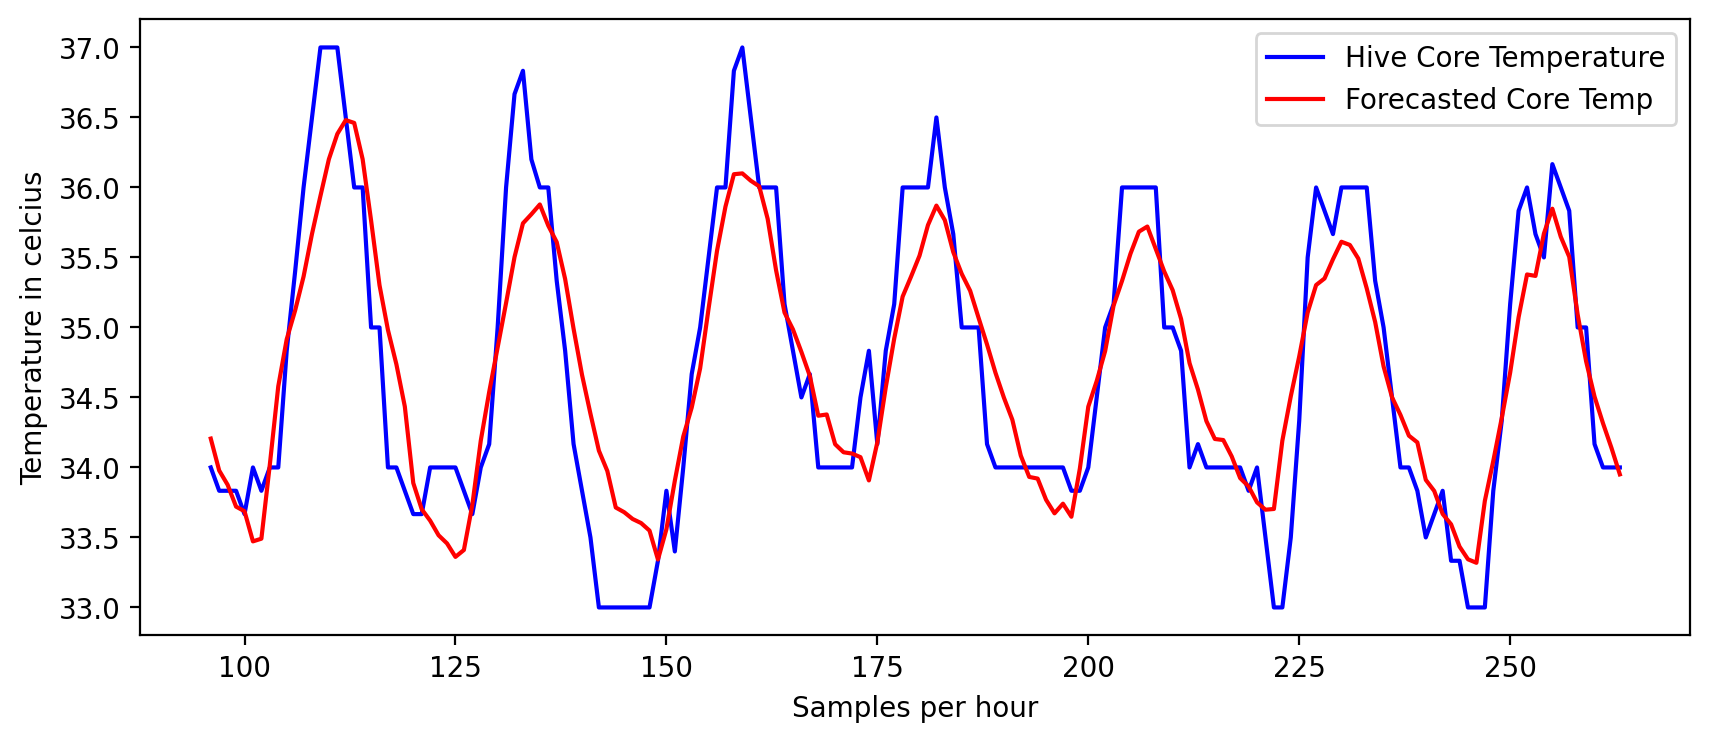

33.76111239717079
33.60346053355215
33.54892273804683
33.537881588657626
33.493246609628216
33.40155087781835
33.37808144173812
33.656950089995746
34.037038521196735
34.45180417002638
34.794750959716964
35.12062381378257
35.48302326416689
35.87289301745869
36.20915245443604
36.238579564620125
36.13741491655475
35.96180162583971
35.65896696058621
35.20785916748366
34.822092108180925
34.55989493290235
34.352254670743775
34.15939981247436
33.97951409747503
33.85205194744242
33.71987095925073
33.58177609241994
33.47063585909666
33.43633472506531
33.36625984458186
33.71987095925073
34.084440068193146
34.45180417002638
34.74027588448598
35.188312498566404
35.56955253981175
35.9105577430754
36.01429116702201
35.88537720593689
35.60272421006516
35.34766186227802
35.006870858427305
34.69505009109463
34.541895081906546
34.29761244436605
34.103276499453216
33.96016916212119
33.862010329708085
33.771339886875126
33.667529663392884
33.60346053355215
33.51565972654112
33.44782089970886
33.4363347250

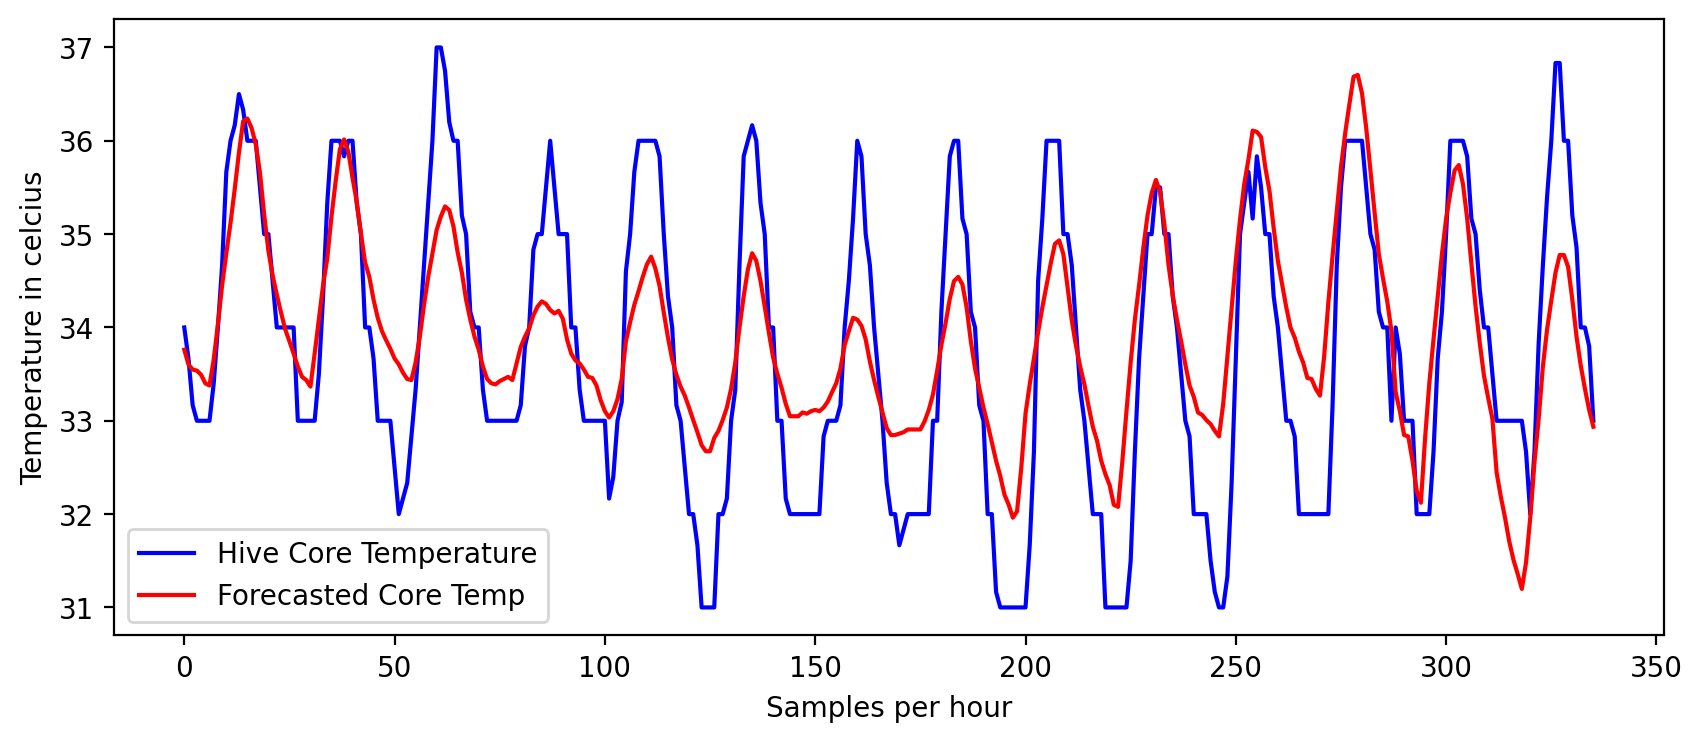

hello 5


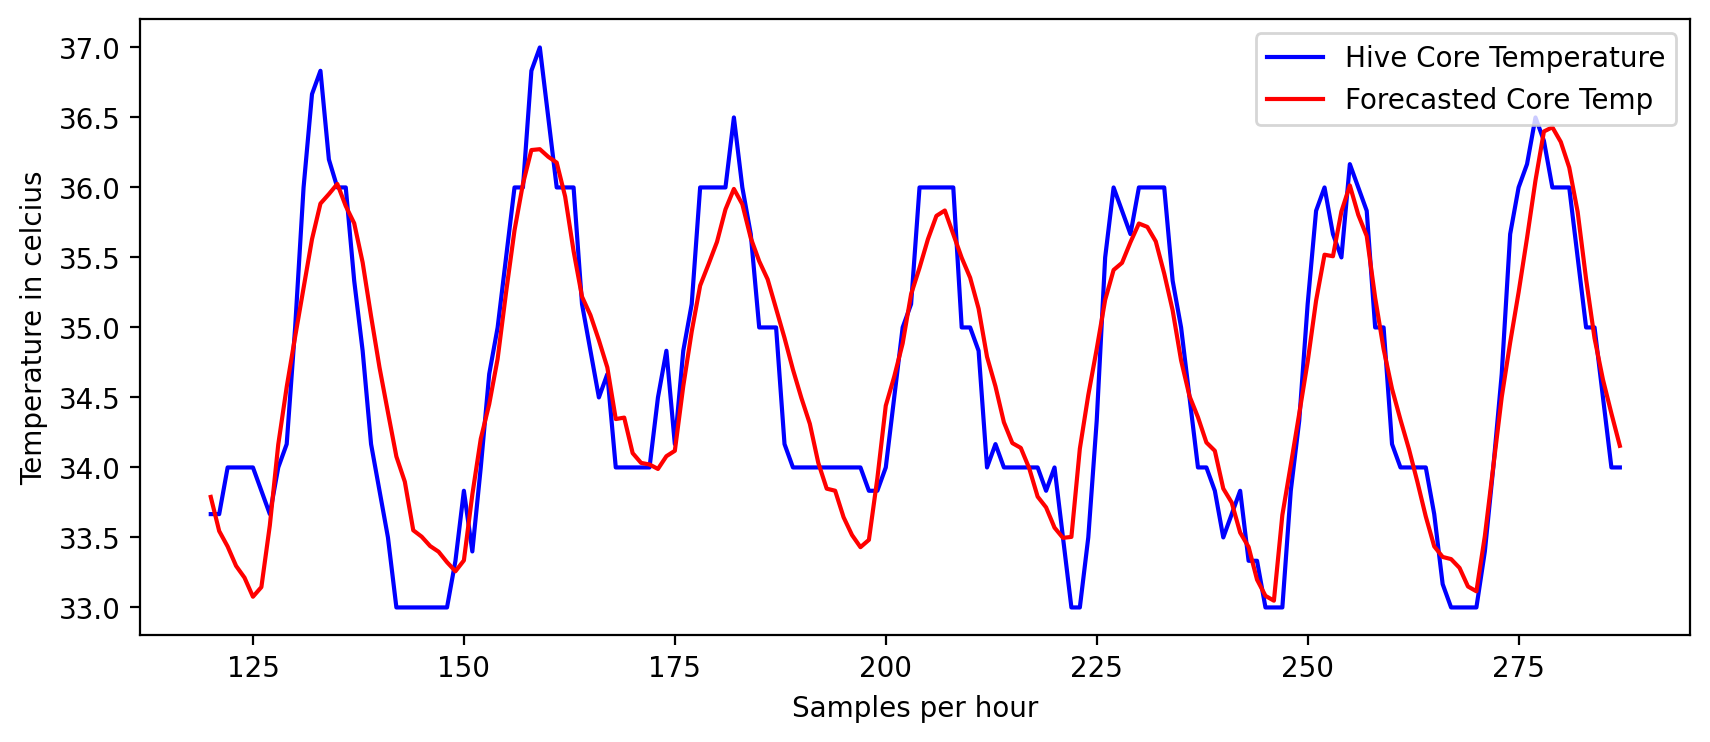

33.93164229907808
33.7686368076632
33.59445702544241
33.40615438813853
33.249352377785954
33.19993653764192
33.097401135798975
33.59445702544241
34.06258544373452
34.50212661306438
34.83136469994122
35.32390985725942
35.730991972898494
36.08912779446405
36.197273834470025
36.06282715076054
35.7660385832512
35.495118228965055
35.126681597952086
34.78048802468663
34.606218725591475
34.32084533335819
34.08580767851993
33.90719248813133
33.78153939419644
33.662943674197265
33.523889954066306
33.43618359361329
33.31347144511068
33.2165396396976
33.19993653764192
33.4658062404759
33.83251459680139
34.25515472904681
34.606218725591475
34.89232356558131
35.167808172347065
35.32390985725942
35.44096895222043
35.398096036868765
35.209117867954944
34.9024795092742
34.65775656579552
34.32084533335819
34.06258544373452
33.83251459680139
33.64940391983737
33.40615438813853
33.2165396396976
33.149309826652484
33.13215301549809
33.18319892729278
33.2165396396976
33.249352377785954
33.19993653764192
33

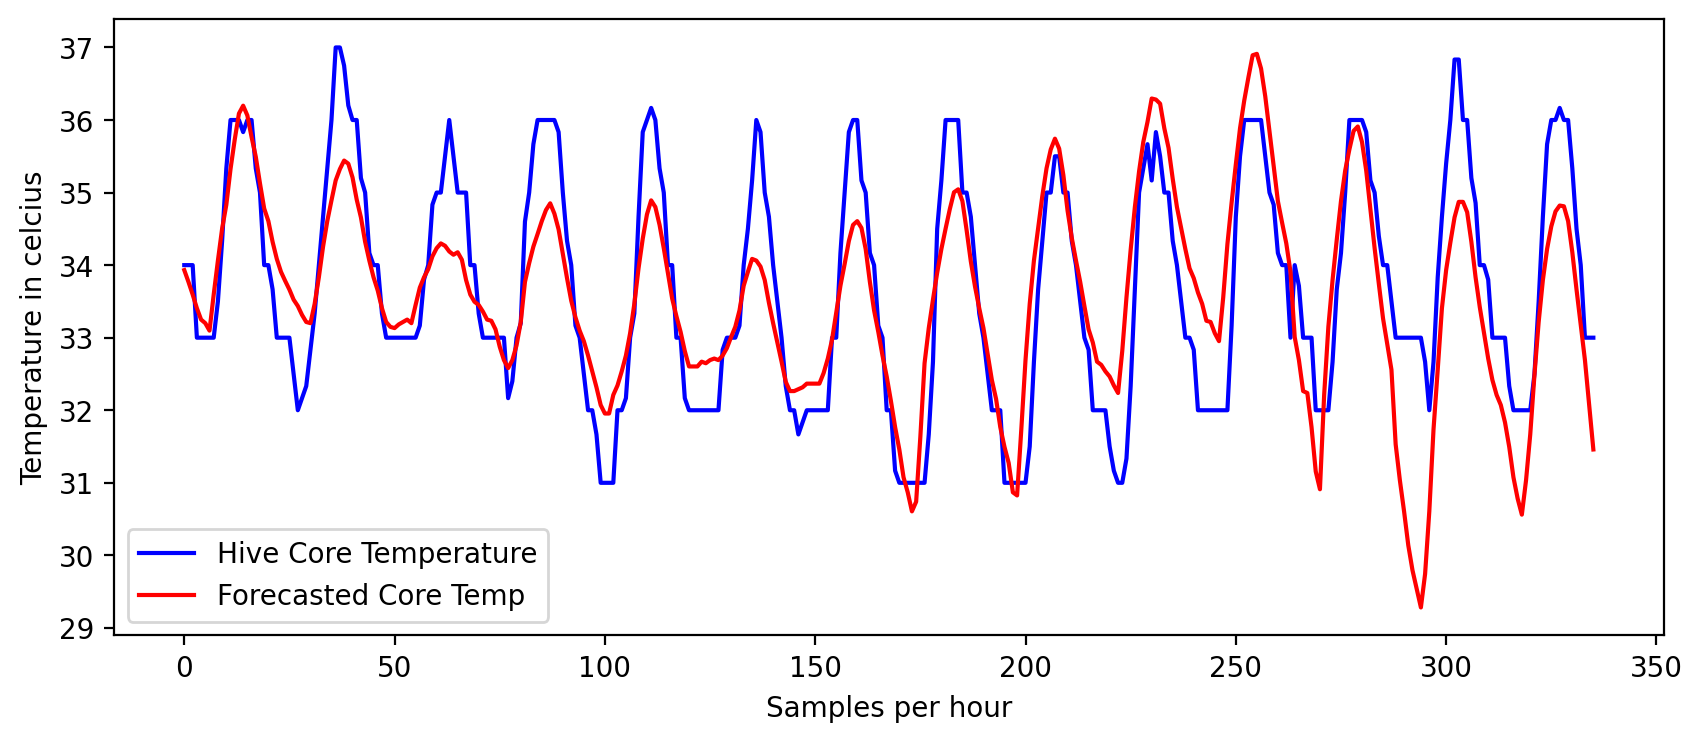

hello 6


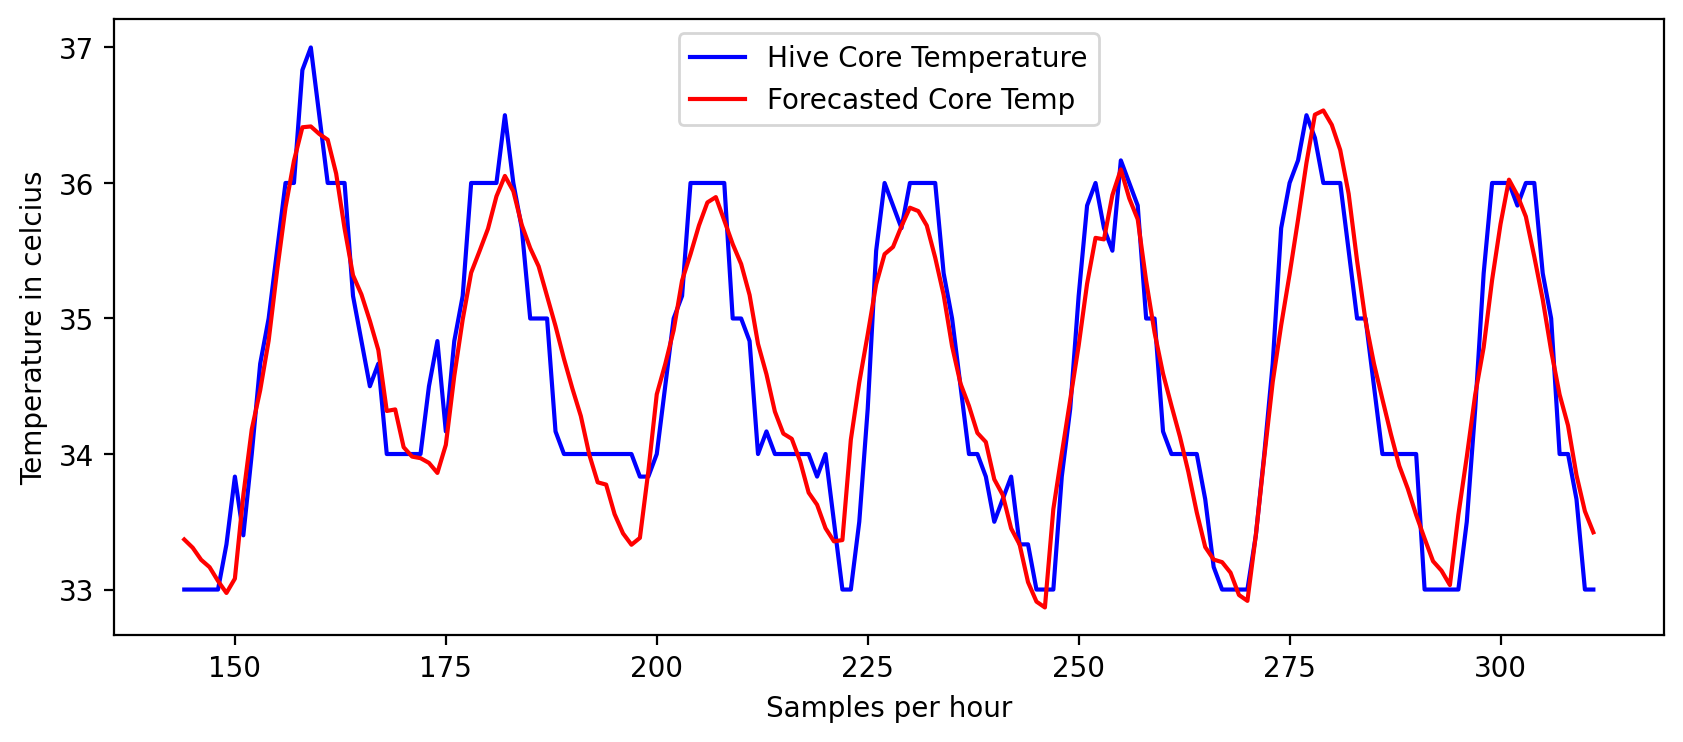

33.56622644789394
33.422063230614356
33.24989117077581
33.13947397024026
32.98255140659194
32.85656876941982
32.83481062956025
33.17692787974312
33.62747001011644
34.12042675715628
34.51344885602424
34.82564041158258
35.12117203100155
35.28694532393064
35.410618841263386
35.36538067811472
35.165145431711665
34.83661451346387
34.570156294737785
34.19495701300389
33.898894013271956
33.62747001011644
33.4054505597212
33.10133724566123
32.85656876941982
32.768144727722245
32.74544380078021
32.812823565773954
32.85656876941982
32.899415812181644
32.83481062956025
33.15828461358609
33.45491583492668
33.62747001011644
33.75973029848501
33.965833247323644
34.09520025587386
34.170297594048236
34.132965797537054
34.0441256047269
33.99216643936683
34.031221418465464
33.91241315957717
33.58169032336673
33.33770007914211
33.21372521508579
33.15828461358609
33.04279181360209
32.899415812181644
32.878102391413165
32.72249564812034
32.399429202566125
32.144898360324305
31.990918152643474
32.1448983603

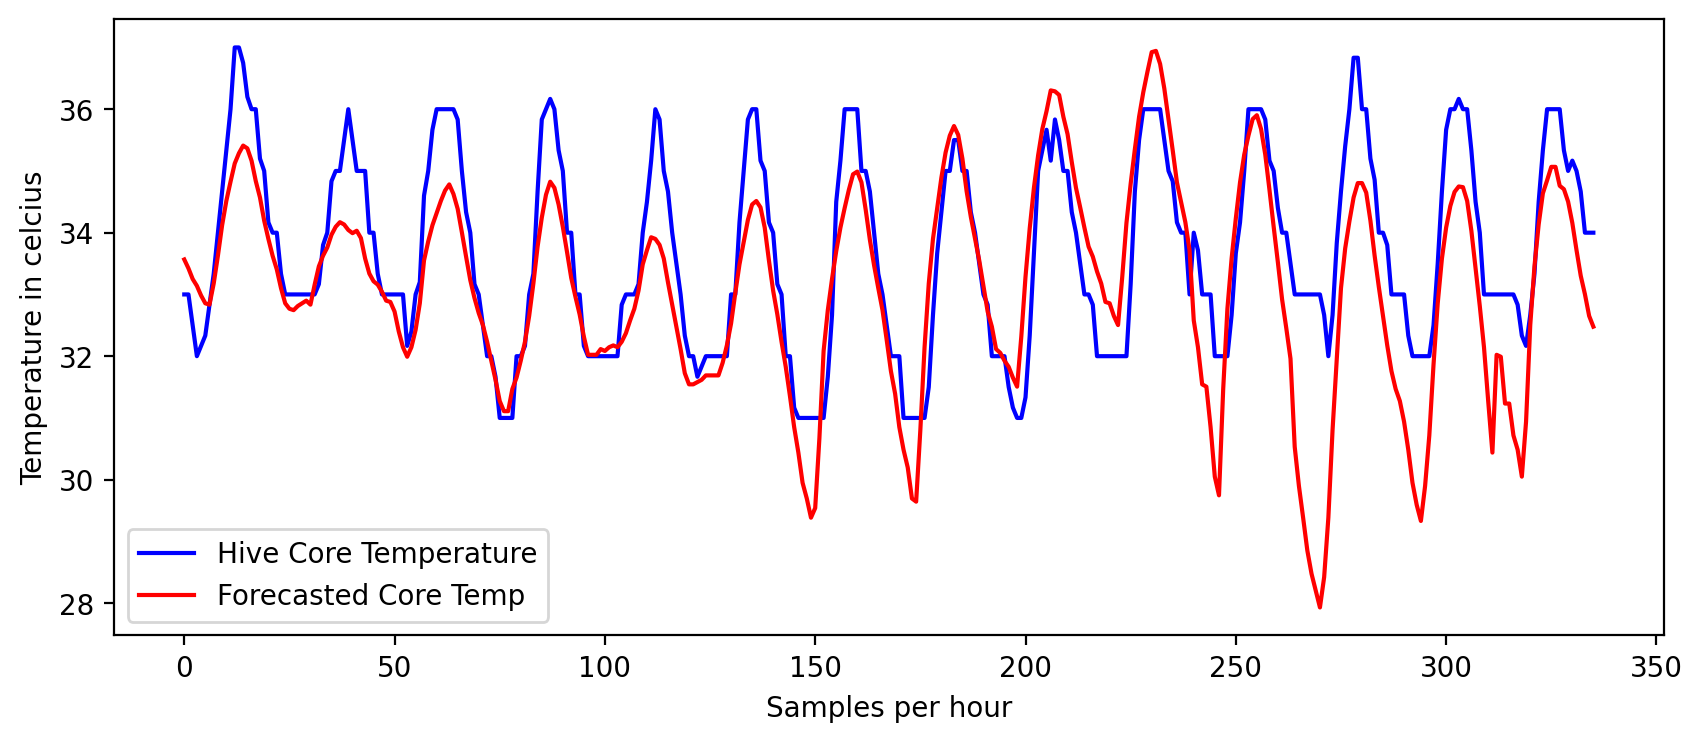

hello 7


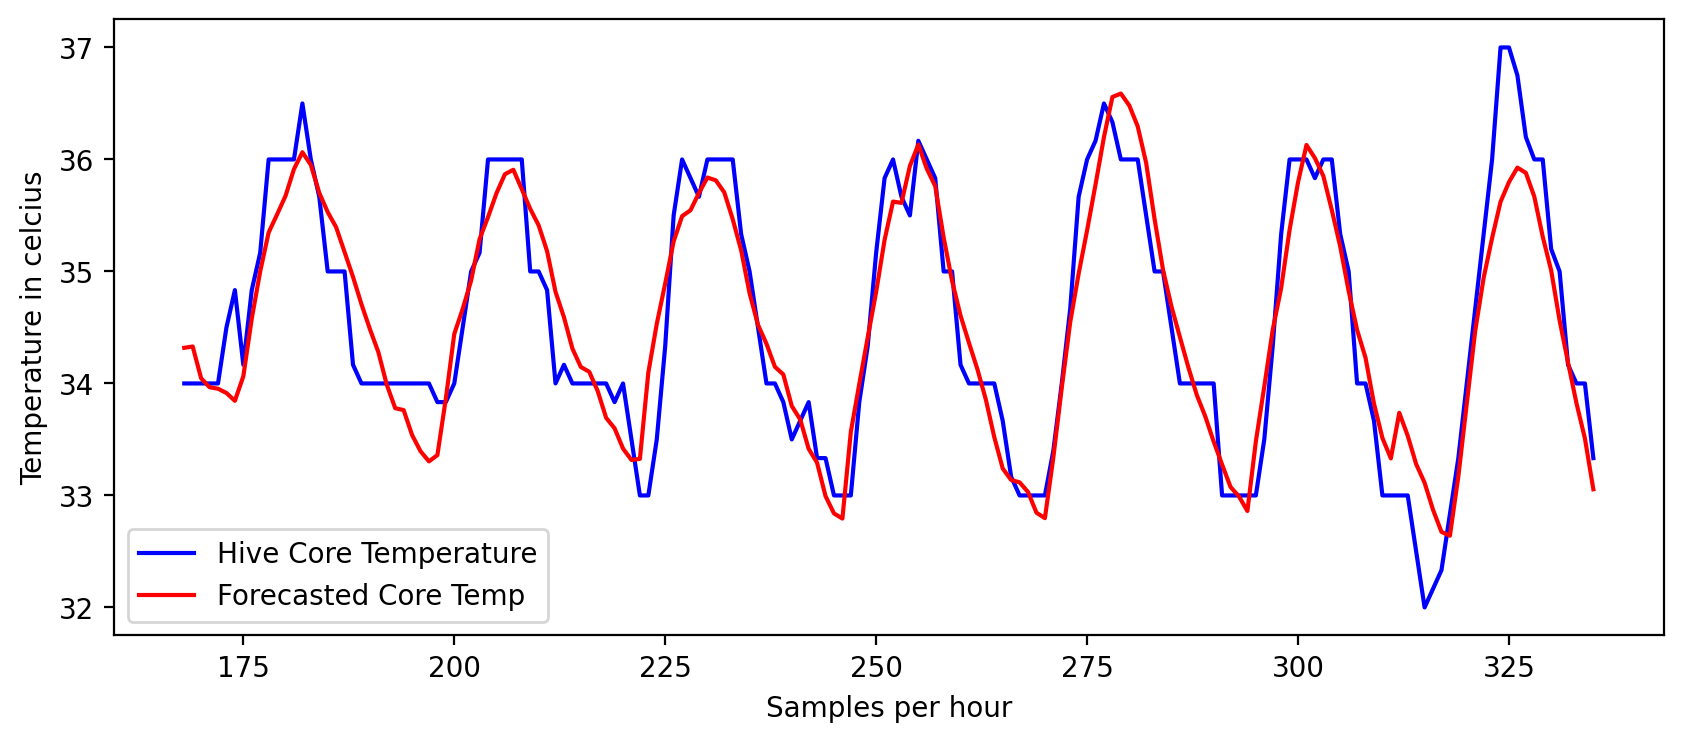

32.674512521972645
32.53495020430506
32.49901518015173
32.605561778632705
32.674512521972645
32.74182694933512
32.64024332569193
33.14174113424258
33.57988909927815
33.82298479336009
34.00331005318196
34.27434530871676
34.43866690751838
34.53215028505707
34.485847648296385
34.374300560456675
34.30814209391963
34.35793449833136
34.205218914195086
33.759359625811726
33.40970571479585
33.22545803671983
33.14174113424258
32.9649833144569
32.74182694933512
32.70837258257319
32.46265784336265
31.95132046063111
31.556614821136918
31.324391238883834
31.556614821136918
31.993184320971466
32.674512521972645
33.71587253578241
34.13390879834492
34.4702208727972
34.70954573455589
34.94346187649171
35.13732200820715
35.24949718680256
35.07376798337077
34.794158574250446
34.324857562271006
33.801984882953775
33.252708431311135
32.80753360114477
32.42587650336583
32.11627865003618
31.691663161603913
31.229174177084133
30.786377580416342
30.324601238654395
30.11474975919208
30.11474975919208
30.5831390

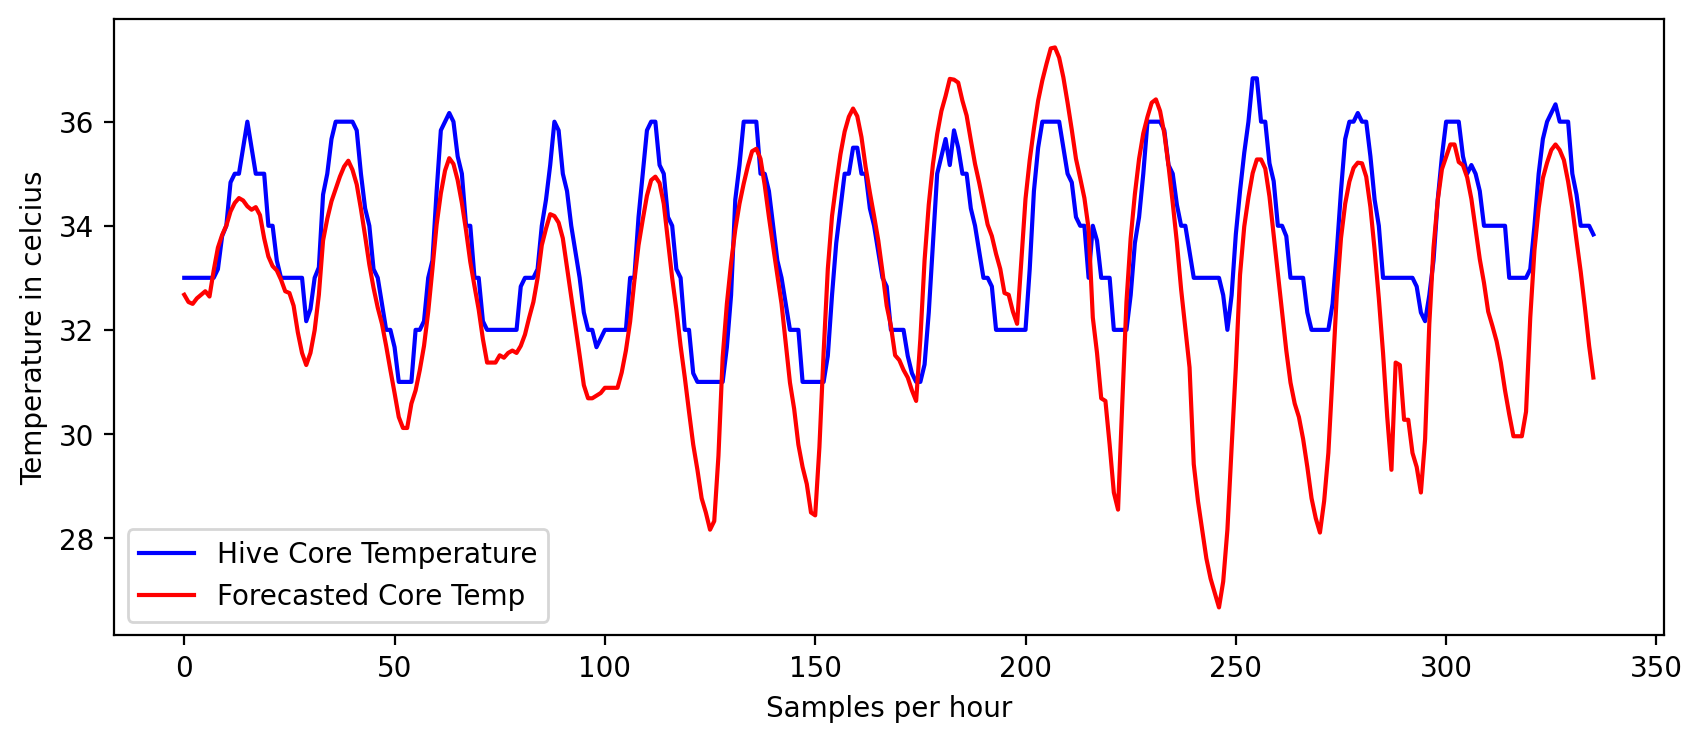

hello 8


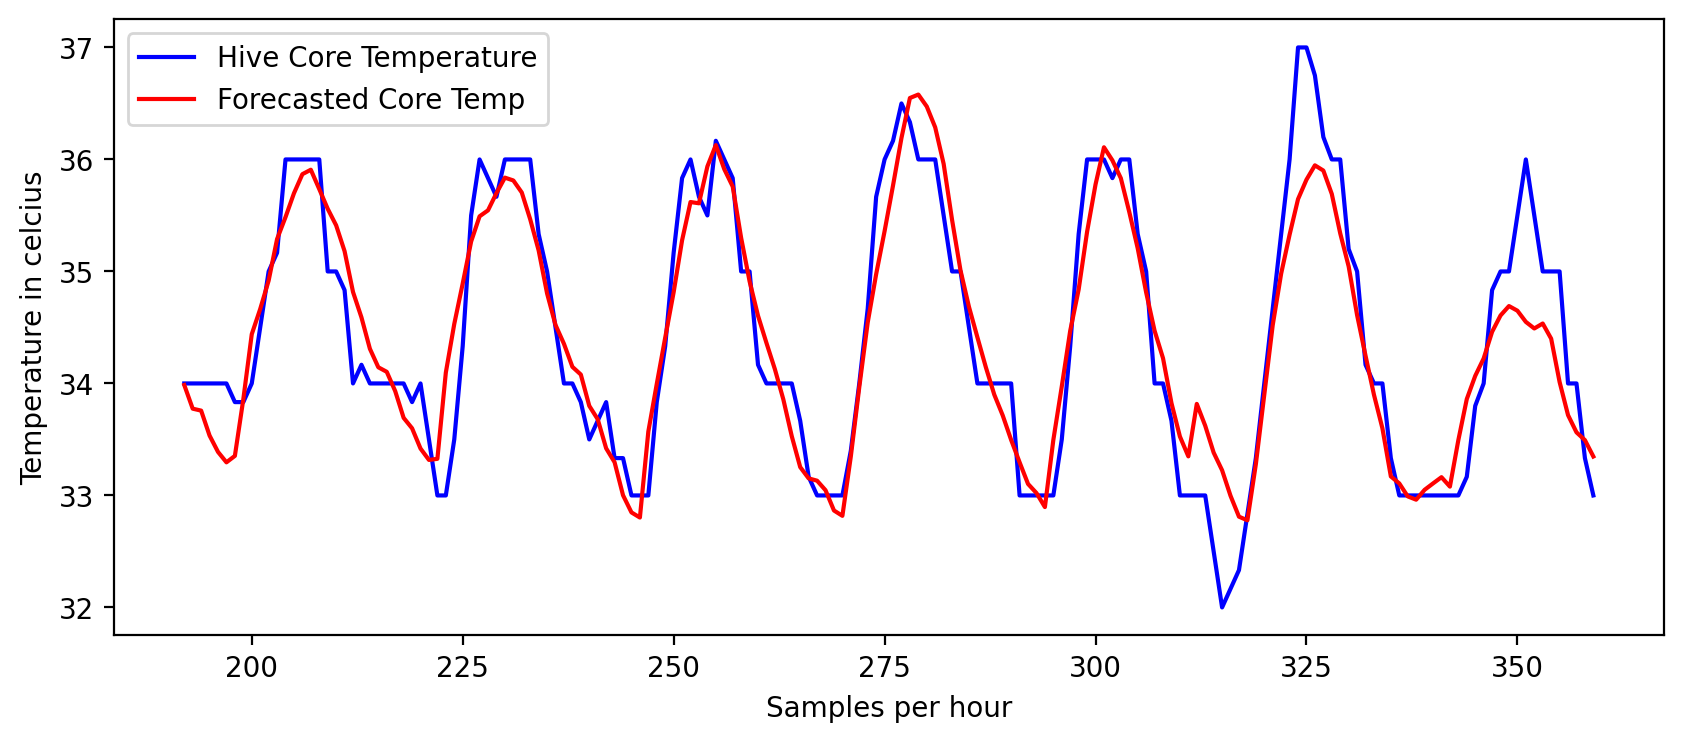

33.165001295463526
33.1375388764169
32.93573226395091
32.511996681688686
32.17772396472873
31.977065795894646
32.17772396472873
32.547016285765665
33.10974532304567
33.97582850787853
34.337107407951294
34.63539998561339
34.85178047982134
35.066348059337884
35.24626877522445
35.35116376457722
35.18708829066537
34.92905741543848
34.505625089769694
34.04942089101485
33.58633282155688
33.21895425884196
32.90547271441733
32.649584918231085
32.29299519411552
31.893854244031616
31.49953231201181
31.075914917349905
30.879665456543364
30.879665456543364
31.314568394367086
31.544882531261408
31.893854244031616
32.29299519411552
32.84383043268457
33.51768786286698
34.239770505931006
34.77253452145152
35.175163882125844
35.397217310230985
35.293126624705565
35.00458944762005
34.607121631821315
34.13800393664826
33.63089218037402
33.24545554528481
32.87484039593534
32.404410725270395
32.018044749665364
32.018044749665364
32.018044749665364
32.13844332429227
32.098735564873095
32.17772396472873
32.2

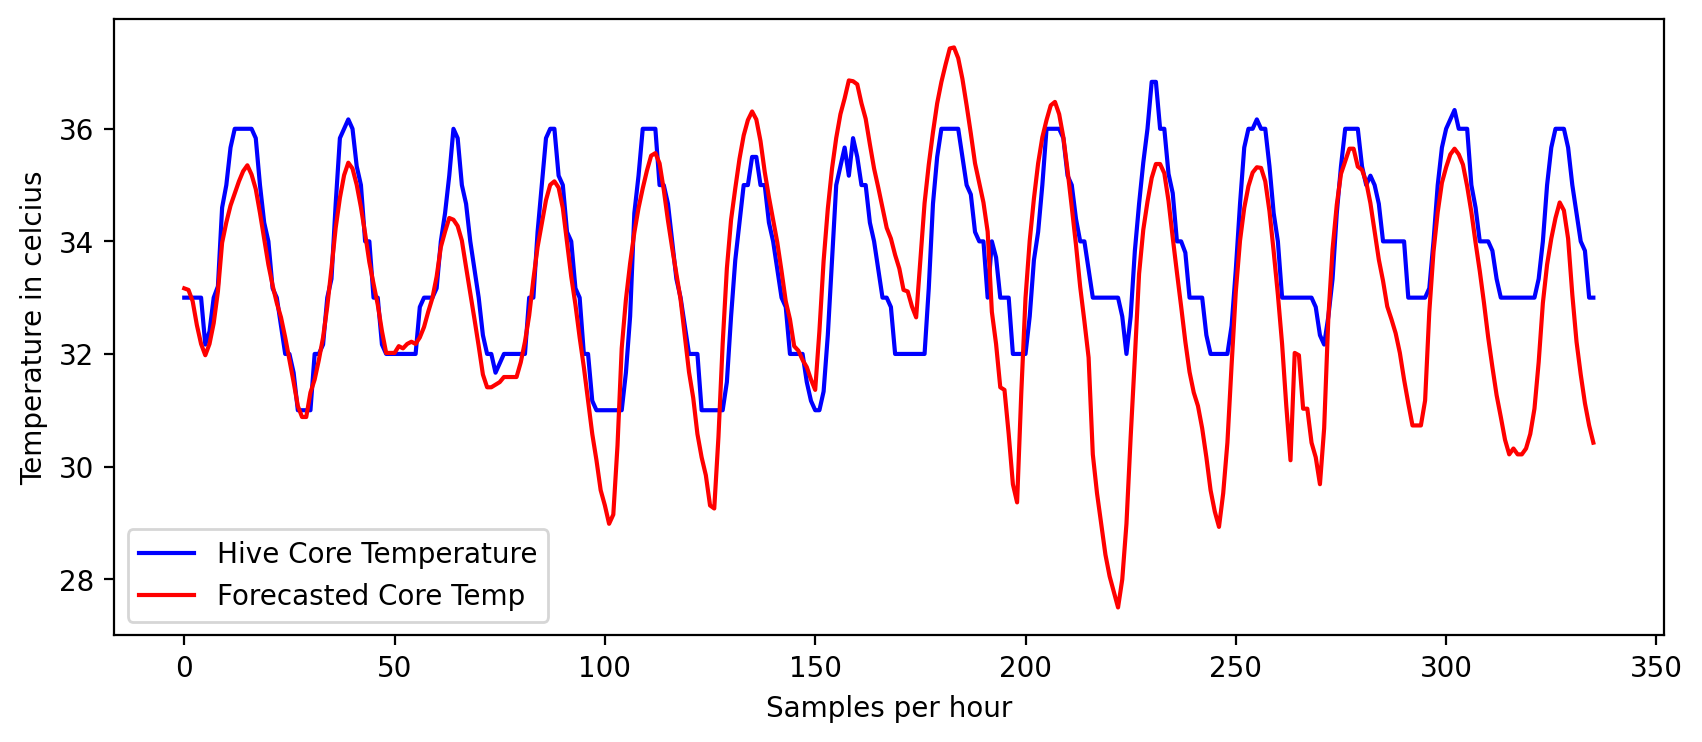

hello 9


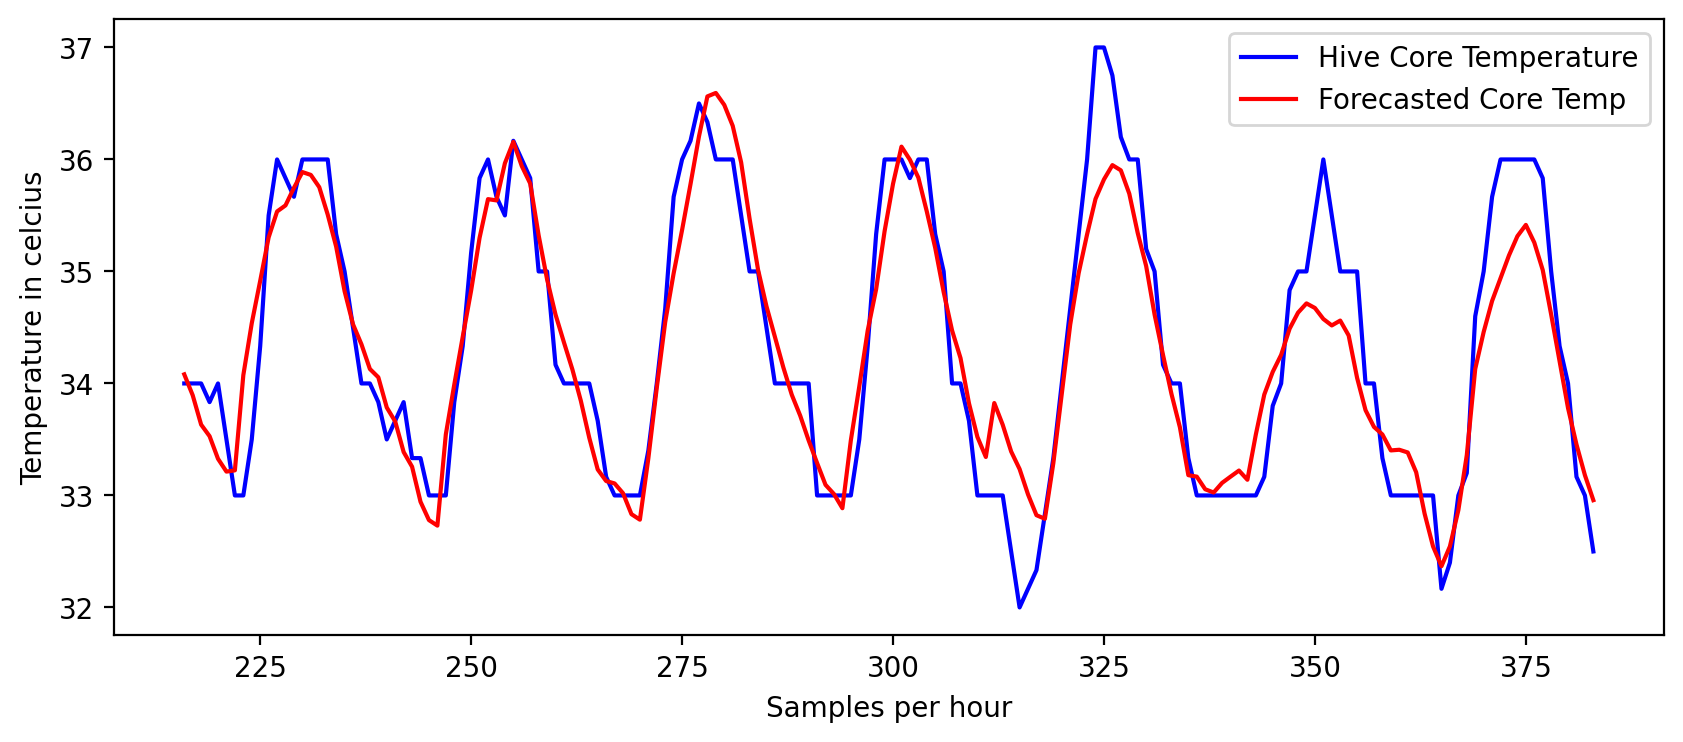

32.64605575214284
32.29439316795464
31.941467270390035
31.5547381916806
31.372802418482365
31.372802418482365
31.773618524931408
31.98238744752024
32.29439316795464
32.64605575214284
33.126754397883076
33.7184498151762
34.369856593060774
34.86515875762478
35.246924191648986
35.45971742171895
35.35979119318512
35.08449402498917
34.710084959355356
34.27666716125594
33.81913677694945
33.478102456992474
33.153800308368716
32.7435224018036
32.40431860652603
32.40431860652603
32.40431860652603
32.51042074460088
32.47547478335633
32.544948746071384
32.57906172379626
32.544948746071384
32.64605575214284
32.806531850210206
33.04363611451981
33.25882605201184
33.59079522750443
34.06018099330049
34.30815829944186
34.531584491417505
34.50297735611173
34.40009539021639
34.1627862894689
33.738982406547734
33.334428914582986
32.927991297104654
32.51042074460088
32.062957231687335
31.858369685508478
31.858369685508478
31.900126979638685
31.941467270390035
32.022884853064284
32.022884853064284
32.02288

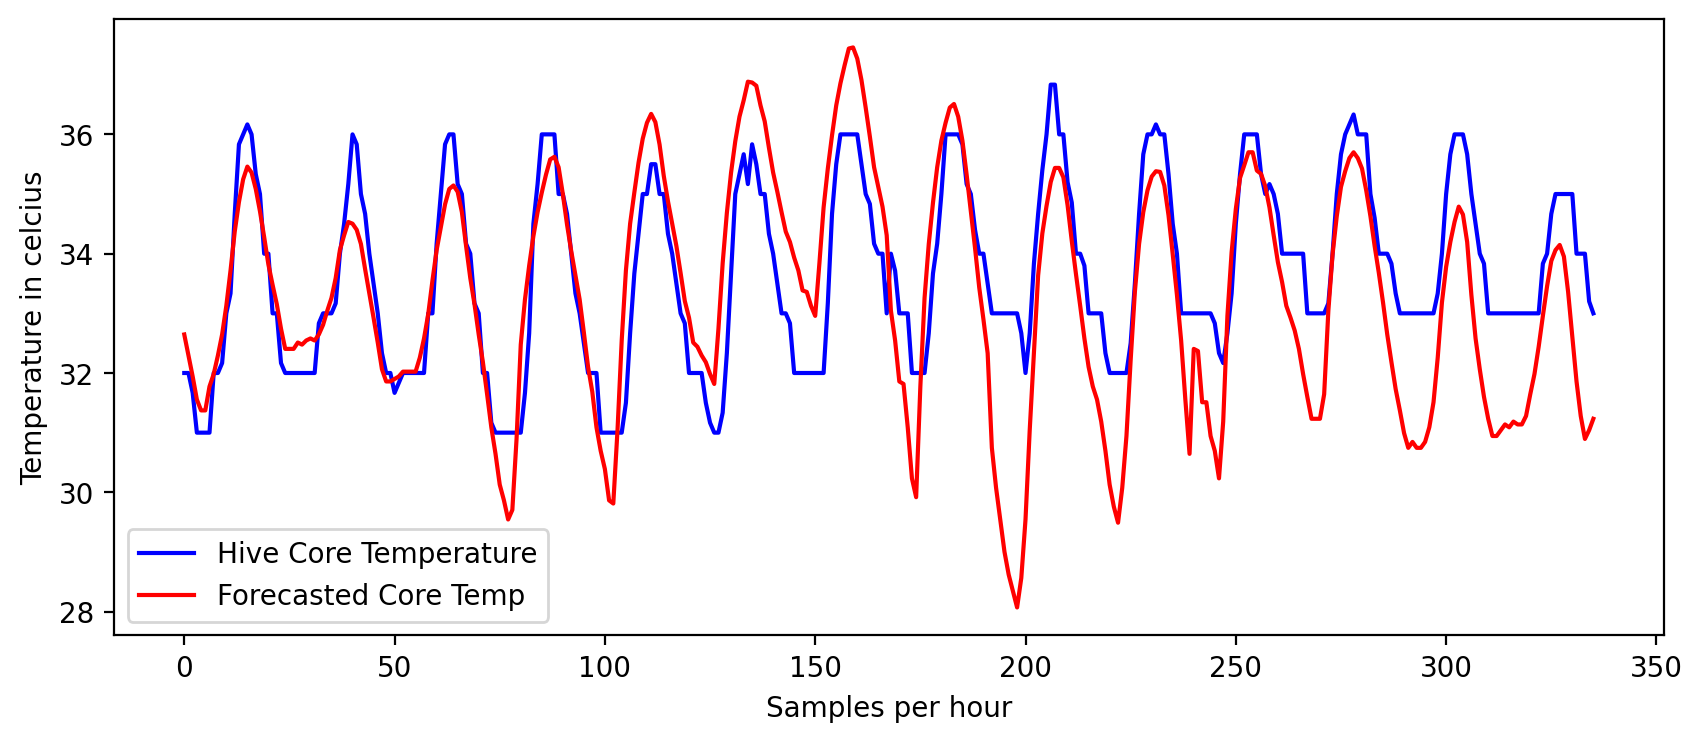

In [29]:
if __name__ == "__main__":
    filename = 'C:\Bee Temp Data\C294_w_Env.csv'
    environment_temperature = 'Air Temp'
    solar_radiation = 'Sol Rad'
    hive_temperature = 'Temp'
    all_temp = main(filename, environment_temperature, solar_radiation, hive_temperature)